In [1]:
from params import FuzzyInputVariable_3Trapezoids, FuzzyInputVariable_2Trapezoids, FuzzyInputVariable_List_Trapezoids
import numpy as np
#from helps_and_enhancers import *
import matplotlib.pyplot as plt
from ANFIS import ANFIS
import time
import copy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

<H1>Przygotowanie zbioru danych<H1>

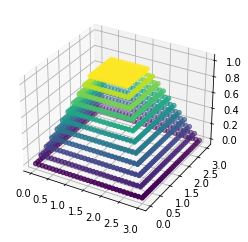

In [2]:
x = np.arange(0, 3.1, 0.1)
x,y = np.meshgrid(x, x)

dataX = x.flatten()
dataY = y.flatten()
dataXY = np.column_stack((dataX,dataY))

data_labels = []
for x, y in zip(dataX, dataY):
    x-=1.5
    y-=1.5
    data_labels.append( abs(x) if (y<x and y>-x) or (y>x and y<-x)  else abs(y) ) 
data_labels=np.array(data_labels)
#data_labels[data_labels>1.5] = 1.5
data_labels=abs(data_labels-1.5)
data_labels[data_labels>1] = 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(dataX, dataY, data_labels, c=data_labels)

plt.show()

<H1>Utworzenie funkcji przynależności</H1>

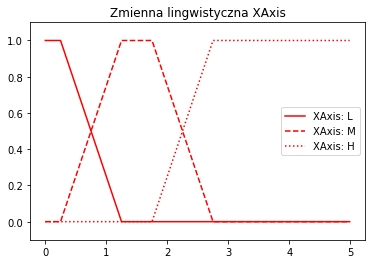

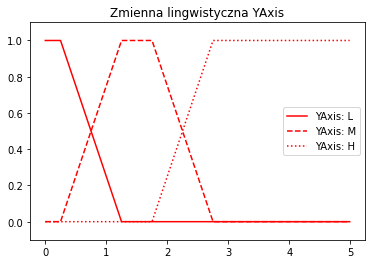

In [3]:
varX = FuzzyInputVariable_3Trapezoids(1.5, 0.5, 1, 1, "XAxis", ["L","M","H"])
varY = FuzzyInputVariable_3Trapezoids(1.5, 0.5, 1, 1, "YAxis", ["L","M","H"])

#Wyświetlanie funkcji przynależnosci
plt.figure()
varX.show(x = np.arange(0, 5, 0.01))
plt.legend()

plt.figure()
varY.show(x = np.arange(0, 5, 0.01))
plt.legend()

plt.show()

<H1>Uczenie systemu ANFIS</H1>

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataXY, data_labels, test_size=0.2, random_state=25)

Optymalizacja zakończona!
z blędem:   18.31704696221581
Liczba ew:  293352
Liczba it:  100
FIS premises [[1.49291251 1.01417447 0.07258914 0.99999637]
 [1.50000037 1.00000263 0.99999879 0.99999763]]
TIME elapsed:  115.00897002220154


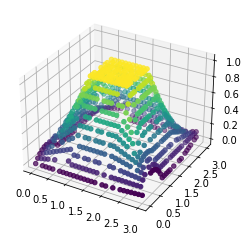

In [5]:


fis = ANFIS([varX, varY], X_train.T, y_train)

start = time.time()
fis.train(True, True, False, True, n_iter=100)
end = time.time()
print("FIS premises", fis.premises)
print("TIME elapsed: ", end - start)   
fis.training_data = X_train.T
fis.expected_labels = y_train
fis.show_results(y_train)

<H1>Zadanie</H1>

Zaimplementuj wszystkie operatory rozmyte pokazane w pliku "Najczęściej stosowane t-normy". Następnie użyj ich do uczenia powyższego systemu ANFIS, która z nich jest najlepsza, jak myślisz dlaczego?

In [6]:
from operators import TNORMS, SNORMS

In [7]:
from dataclasses import dataclass

@dataclass
class TrainResult:
    anfis: ANFIS =None
    elapsed_time: float = 0.0
    

@dataclass
class TestResult:
    anfis: ANFIS
    accuracy: float

In [8]:
import concurrent.futures as cf
import utils
from typing import Dict
from copy import deepcopy
from sklearn.metrics import ConfusionMatrixDisplay

train = X_train, y_train
test = X_test, y_test


  
times = {}
snorms_training_results: Dict[str, TrainResult] = {}
tnorms_training_results: Dict[str, TrainResult] = {}

snorms_test_results: Dict[str, TestResult] = {}
tnorms_test_results: Dict[str, TestResult] = {}

if __name__ == "__main__":
    with cf.ProcessPoolExecutor(max_workers=8) as executor:
        _futures = [executor.submit(utils.train, norm_item, train, deepcopy(varX), deepcopy(varY)) for norm_item in SNORMS.items()]
        for future in cf.as_completed(_futures):
            key, model, elapsed_time = future.result()
            snorms_training_results[key] = TrainResult(model, elapsed_time)
            
        _futures = [executor.submit(utils.train, norm_item, train, deepcopy(varX), deepcopy(varY)) for norm_item in TNORMS.items()]
        for future in cf.as_completed(_futures):
            key, model, elapsed_time = future.result()
            tnorms_training_results[key] = TrainResult(model, elapsed_time)
            
 

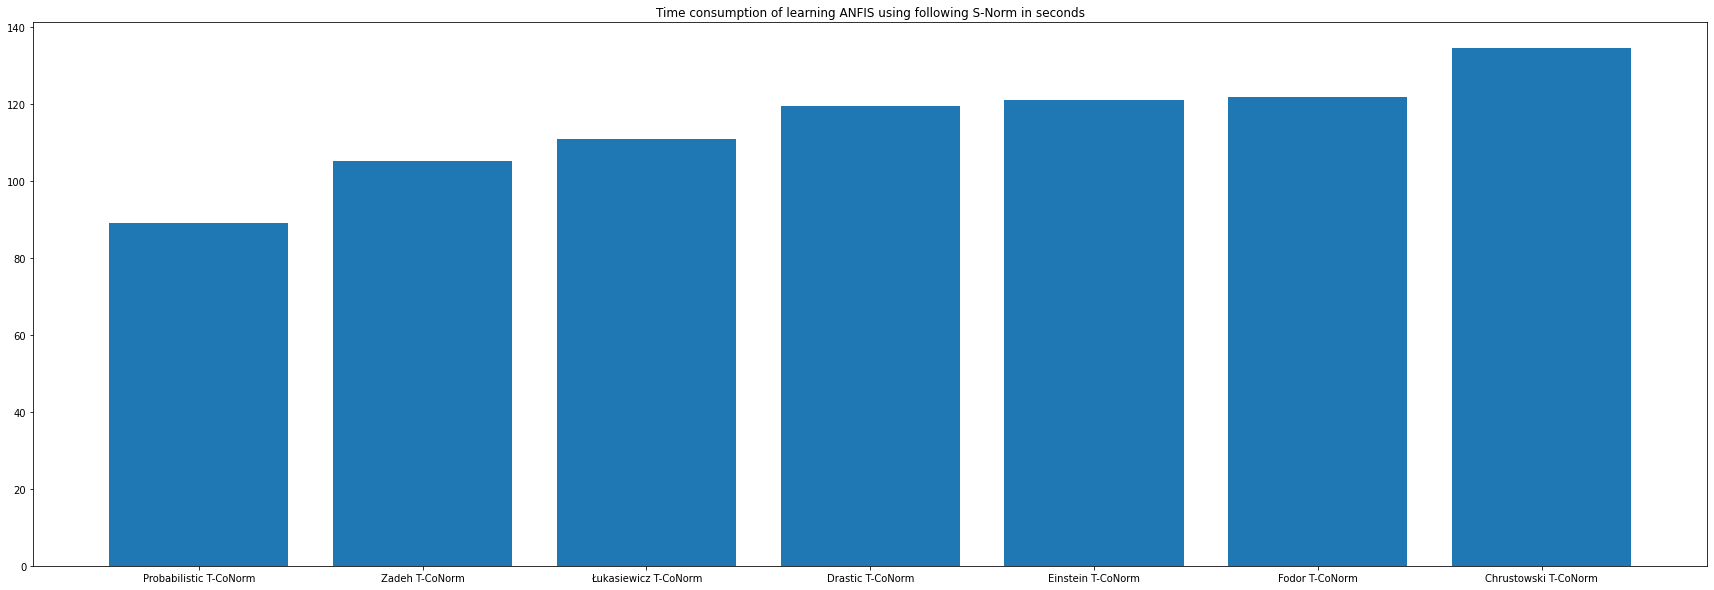

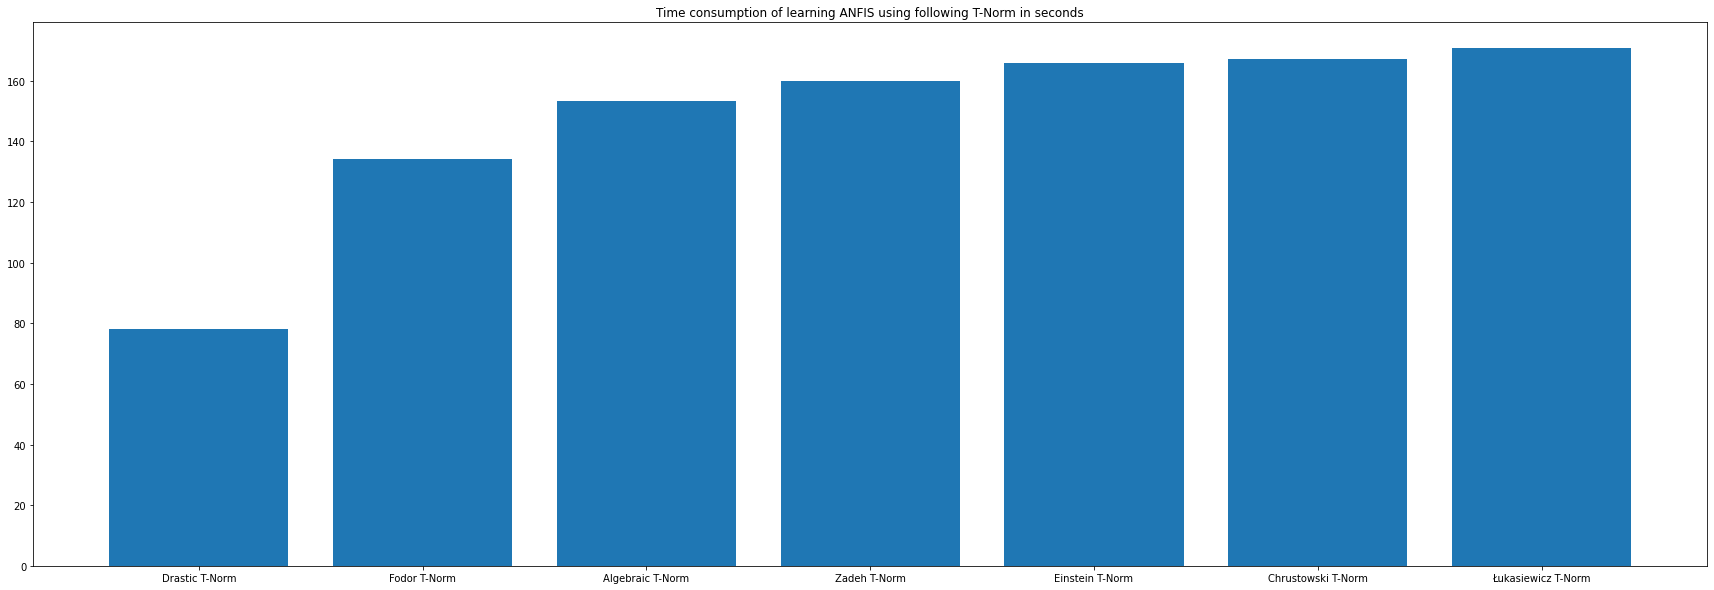

In [9]:
s_norms_elapsed = list(map(lambda result: result.elapsed_time, snorms_training_results.values()))
t_norms_elapsed = list(map(lambda result: result.elapsed_time, tnorms_training_results.values()))

plt.figure(figsize=(30, 10))
plt.bar(list(snorms_training_results.keys()), height=s_norms_elapsed)
plt.title("Time consumption of learning ANFIS using following S-Norm in seconds")
plt.show()
plt.figure(figsize=(30, 10))
plt.bar(list(tnorms_training_results.keys()), height=t_norms_elapsed)
plt.title("Time consumption of learning ANFIS using following T-Norm in seconds")
plt.show()

In [10]:
if __name__ == "__main__":
    from snorms import TESTS
    TESTS[0] = True
    
    with cf.ProcessPoolExecutor(max_workers=8) as executor:
        _futures = [executor.submit(utils.test, result.anfis, test, _id) for _id, result in snorms_training_results.items()]
        for future in cf.as_completed(_futures):
            key, model,  accuracy = future.result()
            snorms_test_results[key] = TestResult(model,  accuracy)
        
        _futures = [executor.submit(utils.test, result.anfis, test, _id) for _id, result in tnorms_training_results.items()]
        for future in cf.as_completed(_futures):
            key, model,  accuracy = future.result()
            tnorms_test_results[key] = TestResult(model, accuracy)   

Accuracy:  0.0 ; of:  Einstein T-CoNorm


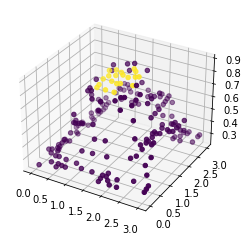

Accuracy:  0.031088082901554404 ; of:  Zadeh T-CoNorm


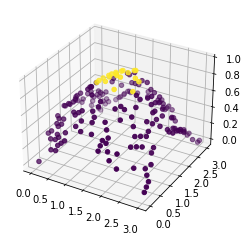

Accuracy:  0.05699481865284974 ; of:  Drastic T-CoNorm


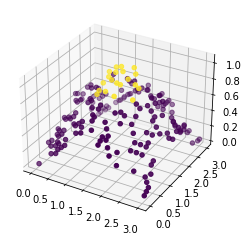

Accuracy:  0.05181347150259067 ; of:  Łukasiewicz T-CoNorm


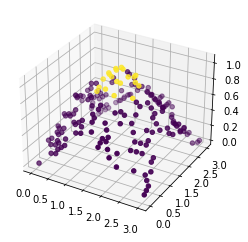

Accuracy:  0.06735751295336788 ; of:  Probabilistic T-CoNorm


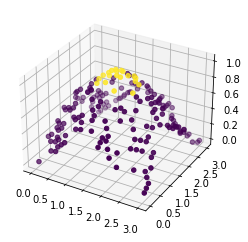

Accuracy:  0.06735751295336788 ; of:  Fodor T-CoNorm


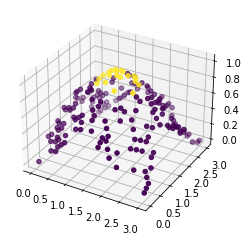

Accuracy:  0.07253886010362694 ; of:  Chrustowski T-CoNorm


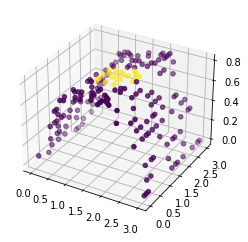

In [11]:
for key, s_test_result in snorms_test_results.items():
    print("Accuracy: ",s_test_result.accuracy, "; of: ", key)
    s_test_result.anfis.show_results(s_test_result.anfis.expected_labels)

Accuracy:  0.15544041450777202 ; of:  Fodor T-Norm


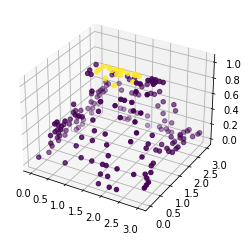

Accuracy:  0.16062176165803108 ; of:  Algebraic T-Norm


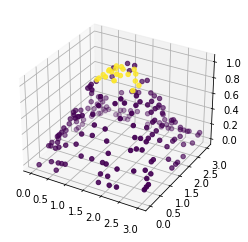

Accuracy:  0.18652849740932642 ; of:  Zadeh T-Norm


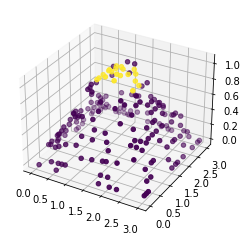

Accuracy:  0.18134715025906736 ; of:  Einstein T-Norm


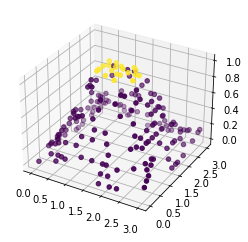

Accuracy:  0.2694300518134715 ; of:  Drastic T-Norm


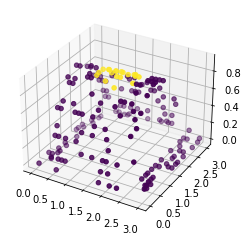

Accuracy:  0.22797927461139897 ; of:  Łukasiewicz T-Norm


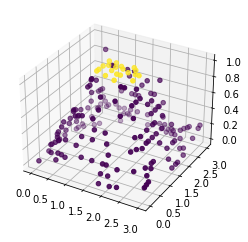

Accuracy:  0.17098445595854922 ; of:  Chrustowski T-Norm


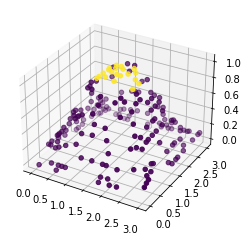

In [13]:
for key, t_test_result in tnorms_test_results.items():
    print("Accuracy: ",t_test_result.accuracy, "; of: ", key)
    t_test_result.anfis.show_results(t_test_result.anfis.expected_labels)